# Petrovsky-Nadeau Zhang Simulations

#### Simon Mishricky

This notebook aims to replicate Panel D of Table 1 of Petrovsky-Nadeau and Zhang (2017). We begin by specifying the problem

The first order conditions are:

$$\frac{\kappa_t}{q(\theta_t)} - \lambda_t = \beta \mathbb{E}\left[\left(X_{t + 1} - W_{t + 1} \right) +(1 - s) \left(\frac{\kappa_{t + 1}}{q(\theta_{t + 1})} - \lambda_{t + 1} \right) \right]$$

$$N_{t + 1} = (1 - s)N_t + q(\theta_t)V_t$$

$$W_t = \eta \left(X_t + \kappa_t \theta_t\right) + \left(1 - \eta \right)b$$

$$\kappa_t = \kappa_K X_t + \kappa_W X_t^{\xi} \quad \kappa_K, \kappa_W, \xi >0$$

$$\ln(X_{t + 1}) = \rho \ln(X_t) + \sigma \epsilon_{t + 1} \quad \epsilon \sim N(0, 1)$$

$$\lambda_t q(\theta_t) V_t = 0$$

$$\lambda_t \geq 0$$

$$q(\theta_t)V_t \geq 0$$

The last two conditions are the Karush Kuhn Tucker conditions associated with the non-negativity constraint on investment: either the constraint does not bind, in which case $\lambda = 0$ or gross investment is zero, in which case $\lambda \geq 0$.

In [1]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import statsmodels.api as sm
from sparsepea.models import dmp_jit
from sparsepea.tools import tools

In [2]:
def initial_guess_dmp(grid_states, γ):
    '''This function provides the initial guess for the PEA algorithm
       in the Diamond Mortensen Pissarides model given a grid of the
       state space'''
    
    grid_size = grid_states[:, 1].size
    
    # Storage space
    guess = np.zeros([grid_size, 1])
    
    for i in range(grid_size):
        
        state = grid_states[i, :]
        x, y = state[0], state[1]
        
        guess[i, :] = γ[0] + γ[1] * x + γ[2] * y
        
    return guess

def simulation(θ_grid, λ_grid, n_initial, x_initial, ts_length=25000, burn=1000):
    '''This function provides simulations for all of the key variables
       in the Diamond Mortensen Pissarides Model'''
    
    # Extract primitive parameters from dmp model
    ρ = dmp_model.ρ
    σ = dmp_model.σ
    s = dmp_model.s
    κ_k = dmp_model.κ_k
    κ_w = dmp_model.κ_w
    η = dmp_model.η
    b = dmp_model.b
    ξ = dmp_model.ξ
    ι = dmp_model.ι
    
    # Storage space
    x = np.ones(ts_length)
    n = np.ones(ts_length)
    w = np.ones(ts_length-1)
    θ = np.ones(ts_length-1)
    y = np.ones(ts_length-1)
    v = np.ones(ts_length-1)
    u = np.ones(ts_length-1)
    λ = np.ones(ts_length-1)
    
    # Initial values
    n[0] = n_initial
    x[0] = x_initial
    ϵ = np.random.randn(ts_length - 1)
    
    # x bounds
    x_min = np.exp((-3.4645 * σ) / np.sqrt(1.0 - ρ**2.0))
    x_max = np.exp((3.4645 * σ) / np.sqrt(1.0 - ρ**2.0))
    
    for t in range(ts_length - 1):
        
        # Evaluate next period shock and check if it fits within the bounds
        x_val = np.exp(ρ * np.log(x[t]) + σ * ϵ[t])
        x_check = np.minimum(x_val, x_max)
        x[t + 1] = np.maximum(x_check, x_min)
        
        # Create and object ready for interpolation using Tasmanian
        state = np.array([[n[t], x[t]]])
        
        # Interpolate to find θ from the policy function given the current state
        θ_val = tool_box.sparse_interpolate(state, θ_grid)[0][0]
        θ[t] = np.maximum(θ_val, 0.0)
        
        # Interpolate to find λ from the policy function given the current state
        λ_val = tool_box.sparse_interpolate(state, λ_grid)[0][0]
        λ[t] = np.maximum(λ_val, 0.0)
        
        # This function calculates the vacancy filling rate
        q = lambda θ: 1 / ((1 + θ**ι)**(1 / ι))
        
        v[t] = θ[t] * (1 - n[t])                     # Vacancies
        
        u[t] = 1 - n[t]                              # Unemployment
        
        κ = κ_k * x[t] + κ_w * x[t]**(ξ)
        
        w[t] = η * (x[t] + κ) + (1 - η) * b          # Wage
        
        n[t + 1] = (1 - s) * n[t] + q(θ[t]) * v[t]   # Next period employment
        
        y[t] = x[t] * n[t]                           # Output
        
    return n[burn:ts_length-1], θ[burn:ts_length-1], w[burn:ts_length-1], y[burn:ts_length-1], v[burn:ts_length-1], u[burn:ts_length-1], λ[burn:ts_length-1], x[burn:ts_length-1]

def plot_simulations(variables, labels):
    '''This function plots the simulations calculated from the 
        simulation function'''
    
    colors = np.array(["blue", "orange", "green", "red", "purple", "black", "pink", "grey"])
    location = np.array([1, 4, 1, 1, 1, 1, 1, 4])
    
    fig, ax = plt.subplots(4, 2,figsize=(8, 6), sharex=True)
    ax = ax.flatten()
    
    for i in range(labels.size):
        ax[i].plot(variables[i], lw=0.8, color=colors[i])
        ax[i].grid(True)
        ax[i].legend([labels[i]], loc=location[i])
        
    plt.tight_layout()
    plt.show()
    
def summary_stats(variables, labels):
    
    # Construct a data frame using store simulation values
    data_frame = np.column_stack((x, n, θ, u, v, λ, w, y))
    df = pd.DataFrame(data_frame, columns=labels)

    # Create a de-meaned data frame to HP filter the data
    Y = df.tail(12000).copy()
    date = pd.date_range(start='1900-01-01', end=None, periods=len(Y), freq='W')
    Y["week starting"] = date
    Q = Y.resample('Q', on='week starting').mean()
    Q = Q.divide(Q.mean())
    
    # HP filter the data
    Y_cycle = {}
    Y_trend = {}

    for key, series in Q.iteritems():
        Y_cycle[key], Y_trend[key] = sm.tsa.filters.hpfilter(series, 1600)

    Y_cycle = pd.DataFrame.from_dict(Y_cycle)
    Y_trend = pd.DataFrame.from_dict(Y_trend)
    
    # Calculate the standard deviation and autocorrelation of the variables
    st_dev = {}
    acf = {}
    for key, series in Y_cycle.iteritems():
        st_dev[key] = series.std()
        acf[key] = series.autocorr(lag=1)
    
    # Construct data frames from the calculated standard deviation and autocorrelation values
    st_dev = pd.DataFrame.from_dict(st_dev, orient='index', columns=["Standard deviation"])
    acf = pd.DataFrame.from_dict(acf, orient='index', columns=["Autocorrelation"])    
    
    # Reshape the data frame to only include the variables of consideration
    st_dev = st_dev.iloc[[3, 4, 2, 0]]
    acf = acf.iloc[[3, 4, 2, 0]]
    df_proj = pd.concat([st_dev, acf], axis=1)
    df_y = Y_cycle[['Unemployment', 'Vacancies', 'Tightness', 'Technology']].corr()
    data = pd.concat([df_proj.T, df_y]).round(3)
    table = data.drop(index='Technology')
    
    return table

In [3]:
# Parameters required for the initial guess needed for the PEA algorithm
γ_dmp = np.array([-20, 23.18875328038525, 0.0])

# Initial values required for the simulations
n_initial = 0.0
x_initial = 0.947273

In [4]:
# Initialise an instance of the dmp model
dmp_model = dmp_jit()

# Initialise tools class given the dmp model
tool_box = tools(model=dmp_model, max_iter=1000)
grid_dmp, grid_states_dmp = tool_box.make_states_grid()

# Make a sparse grid require to generate an initial guess
e_dmp = initial_guess_dmp(grid_states_dmp, γ_dmp)

# Solve for the optimal Euler equation and tightness function
e_p, θ_grid, λ_grid, count_dmp = tool_box.compute_solution(e_dmp)
print(count_dmp)

Convergence successful: 521 Iterations


In [5]:
# Run the simulations
n, θ, w, y, v, u, λ, x = simulation(θ_grid, λ_grid, n_initial, x_initial)

In [6]:
labels = np.array(["Technology",
                   "Employment",
                   "Tightness",
                   "Unemployment",
                   "Vacancies", 
                   "Multiplier",
                   "Wage",
                   "Output"])

variables = np.asarray([x, n, θ, u, v, λ, w, y])

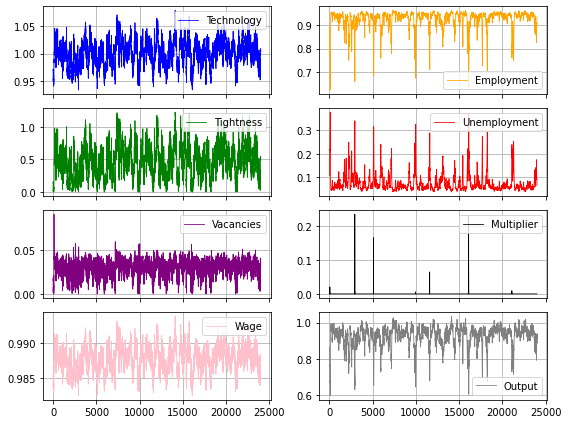

In [7]:
# Plot the simulations
plot_simulations(variables, labels)

In [8]:
data = summary_stats(variables, labels)

# Reformat the table to match the Petrovsky-Nadeau and Zhang (2017) Table
label = np.array(["Unemployment", "Vacancies", "Tightness"])

for i in range(label.size):
    for j in range(label.size):
        if i >= j:
            data.loc[label[i], label[j]] = ' '

data

,Unemployment,Vacancies,Tightness,Technology
Standard deviation,0.312,0.194,0.282,0.013
Autocorrelation,0.838,0.523,0.739,0.739
Unemployment,,-0.462,-0.553,-0.609
Vacancies,,,0.853,0.882
Tightness,,,,0.994


In [9]:
%%html
<style>
table {float:left}
</style>

This table provides the values found in Panel D of Table 1 of Petrovsky-Nadeau and Zhang (2017), you can see here that our values above are quite close to our target


|     | Unemployment | Vacancies | Tightness | Technology |
|---:|------------:|---------:|---------:|----------:|
| **Standard deviation** | 0.257 | 0.174 | 0.267 | 0.013 |
| **Autocorrelation** | 0.823 | 0.586 | 0.759 | 0.760 |
| **Unemployment** | | -0.567 | -0.662 | -0.699|
| **Vacancies** | | | 0.890 | 0.909 |
| **Tightness** | | | | 0.996 |